In [562]:
import numpy as np

import matplotlib.pyplot as plt 
from time import perf_counter_ns

Вычисление $f=u(T,x|q_{exact})$

In [584]:
def solve_pde(q, dx, dt, T): #pde solver for u with eps=0

    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    n = len(t)
    m = len(x)
    U = np.zeros((n+1,m+1))
    U[0,:] = q
    for i in range(0,n):
        for j in range(1,m):
            U[i+1,j] = U[i,j] + dt * (U[i,j] * (U[i,j+1] - 2 * U[i,j] + U[i,j-1])/(dx ** 2) + ((U[i,j+1] - U[i,j-1])/(2*dx)) ** 2 + U[i,j] * (1 - U[i,j])) #step for finite differences method
        #boundary conditions
        U[i+1,0] = U[i+1,1]
        U[i+1,m] = U[i+1,m-1]
    U[n,0] = U[n,1]
    U[n,m] = U[n,m-1]

    return U

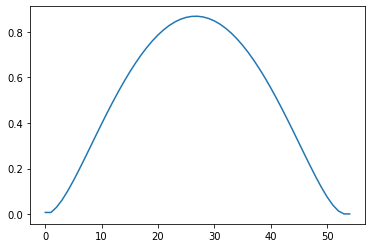

In [585]:
def func(x):
    return (np.sin(np.pi * x)) ** 2

dx = 0.0375 / 2
dt = dx ** 2 / 4

x = np.arange(0, 1, dx)
t = np.arange(0, T, dt)
n = len(t)
m = len(x)

q_exact = np.zeros(m+1)

for i in range(m+1):
    q_exact[i] = func(i*dx)

U = solve_pde(q_exact, dx, dt, T)

f = np.zeros(m+1)

f = U[n, :]

plt.plot(f)

После этого перейдем к самому градиентному методу: 

In [565]:
def solve_cpde(f, U, dt, dx, T): #conjugate pde solver for p --- time-inverted conjugate pde
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    n = len(t)
    m = len(x)
    P = np.zeros((n+1,m+1))
    P[0,:] = 2 * (f - U[n, :])
    for i in range(0,n):
        P[i+1,0] = P[i+1,1]
        P[i+1,m] = P[i+1,m-1]
        for j in range(1,m):
            P[i+1,j] = P[i,j] + dt * (P[n-i,j] * (P[i,j+1] - 2 * P[i,j] + P[i,j-1])/(dx ** 2) - (2 * U[n-i,j] - 1) * P[i,j])
    P[n,0] = P[n,1]
    P[n,m] = P[n,m-1]
    return P  

In [568]:
def error(f, U, dx):
    s = 0
    for j in range(m+1):
        s = s + dx * (f[j] - U[n,j]) ** 2
    return s

In [567]:
def solve_pde_m(q, dx, dt, T, e): #pde solver for u with eps
    if (e == 0):
        return solve_pde(q, dx, dt, T)
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    n = len(t)
    m = len(x)
    U = np.zeros((n+1,m+1))
    U[0,:] = q
    U[1,:] = q
    for i in range(1,n):
        for j in range(1,m):
            U[i+1,j] = (2*e*U[i,j]/(dt ** 2) -e*U[i-1,j]/(dt ** 2) + U[i,j] / dt + U[i,j] * (U[i,j+1] - 2 * U[i,j] + U[i,j-1])/(dx ** 2) + ((U[i,j+1] - U[i,j])/(dx)) * ((U[i,j+1] - U[i,j-1])/(2*dx)) + U[i,j] * (1-U[i,j]))*(2 * dt * dt)/(e+dt) #step for finite differences method
        #boundary conditions
        U[i+1,0] = U[i+1,1]
        U[i+1,m] = U[i+1,m-1]
    U[n,0] = U[n,1]
    U[n,m] = U[n,m-1]

    return U

In [569]:
def solve_cpde_m(f, U, dt, dx, T, e): #conjugate pde solver for p --- time-inverted conjugate pde with eu_tt
    if (e == 0):
        return solve_cpde(f, U, dt, dx, T)
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    n = len(t)
    m = len(x)
    P = np.zeros((n+1,m+1))
    P[1,:] = 2 * (f - U[n, :]) * dt / e
    for i in range(1,n):
        for j in range(1,m):
            P[i+1,j] = (2*e*P[i,j]/(dt ** 2) -e*P[i-1,j]/(dt ** 2) + P[i,j]/dt  + U[n-i,j] * (P[i,j+1] - 2 * P[i,j] + P[i,j-1])/(dx ** 2) + (1 - 2 * U[n-i,j])* P[i,j])*(2 * dt * dt)/(e+dt)
        P[i+1,0] = P[i+1,1]
        P[i+1,m] = P[i+1,m-1]
    P[n,0] = P[n,1]
    P[n,m] = P[n,m-1]
    return P  


In [570]:
T=0.01

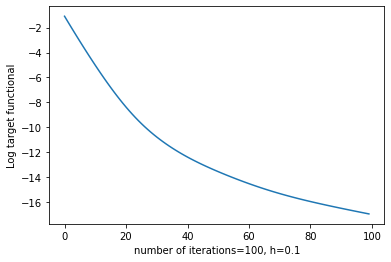

Time elapsed:  35.868062  seconds


In [575]:
#gradient method for eps = 0
#for given q_ex
def exact_init(x):
    return (np.sin(np.pi * x)) ** 2 #set yourself

x = np.arange(0, 1, dx)
t = np.arange(0, T, dt)
n = len(t)
m = len(x)
U = np.zeros((n+1,m+1))
e = 0
P = np.zeros((n+1,m+1))
h = 0.1#set yourself

q = np.zeros(m+1)
n_iter = 100#set yourself

q_ex = np.zeros(m+1)

for i in range(m+1):
    q_ex[i] = exact_init(dx*i)

U = solve_pde_m(q_ex, dx, dt, T, e) #calculating U(t,x|q_ex)
f = U[n,:]

r = np.zeros(n_iter)
grad = np.zeros(m) 
x = np.zeros(n_iter)
for j in range(n_iter):
    time_before = perf_counter_ns()
    P = np.zeros((n+1,m+1))
    U = solve_pde_m(q, dx, dt, T, e) #calculating U(t,x|q)
    P = solve_cpde_m(f, U, dt, dx, T, e)
    grad =  - P[n, :] - e * (P[n,:] - P[n-2,:])/(2*dt) #current grad
    for k in range(m):
        q[k] = q[k] - h * grad[k]
    r[j] = np.log(error(f, U, dx))
    x[j] = j
time_taken = (perf_counter_ns() - time_before) * 1e-6


fig, ax = plt.subplots()
ax.plot(x, r)
ax.set_xlabel('number of iterations=100, h=0.1')
ax.set_ylabel('Log target functional')
plt.show()
print('Time elapsed: ', time_taken, ' seconds')

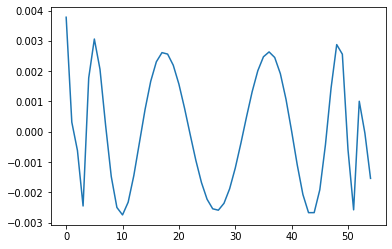

In [576]:
plt.plot(q-q_ex)

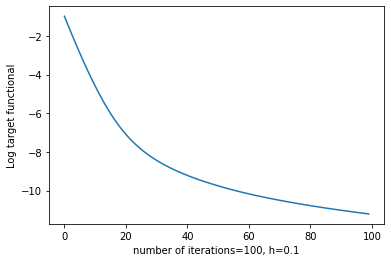

Time elapsed:  34.807758  seconds


In [577]:
#gradient method for eps = 0
#for unknown q_ex given f(x)
x = np.arange(0, 1, dx)
t = np.arange(0, T, dt)
n = len(t)
m = len(x)
U = np.zeros((n+1,m+1))
e = 0
P = np.zeros((n+1,m+1))
h = 0.1#set yourself

q = np.zeros(m+1)
n_iter = 100 #set yourself
for i in range(m+1):
    f[i] = func(dx*i)
r = np.zeros(n_iter)
grad = np.zeros(m) 
x = np.zeros(n_iter)
for j in range(n_iter):
    time_before = perf_counter_ns()
    P = np.zeros((n+1,m+1))
    U = solve_pde_m(q, dx, dt, T, e) #calculating U(t,x|q)
    P = solve_cpde_m(f, U, dt, dx, T, e)
    grad =  - P[n, :] - e * (P[n,:] - P[n-2,:])/(2*dt) #current grad
    for k in range(m):
        q[k] = q[k] - h * grad[k]
    r[j] = np.log(error(f, U, dx))
    x[j] = j
time_taken = (perf_counter_ns() - time_before) * 1e-6


fig, ax = plt.subplots()
ax.plot(x, r)
ax.set_xlabel('number of iterations=100, h=0.1')
ax.set_ylabel('Log target functional')
plt.show()
print('Time elapsed: ', time_taken, ' seconds')

Применение метода экстраполяции Ричардсона для $q$

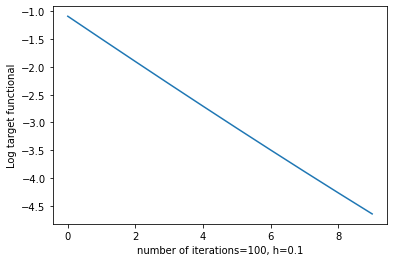

Time elapsed:  1.050481  seconds
0.05 0.0025000000000000005


In [687]:
T=0.01
dx = 0.05
dt = dx ** 2 
x = np.arange(0, 1, dx)
t = np.arange(0, T, dt)
n = len(t)
m = len(x)
U = np.zeros((n+1,m+1))
e = 0
P = np.zeros((n+1,m+1))
h = 0.1#set yourself

q = np.zeros(m+1)
n_iter = 10
f = np.zeros(m+1)
q_ex = np.zeros(m+1)
for i in range(m+1):
    q_ex[i] = func(dx*i)
  
U = solve_pde_m(q_ex, dx, dt, T, e)
f = U[n,:]

r = np.zeros(n_iter)
grad = np.zeros(m) 
x = np.zeros(n_iter)
for j in range(n_iter):
    time_before = perf_counter_ns()
    P = np.zeros((n+1,m+1))
    U = solve_pde_m(q, dx, dt, T, e) #calculating U(t,x|q)
    P = solve_cpde_m(f, U, dt, dx, T, e)
    grad =  - P[n, :] - e * (P[n,:] - P[n-2,:])/(2*dt) #current grad
    for k in range(m):
        q[k] = q[k] - h * grad[k]
    r[j] = np.log(error(f, U, dx))
    x[j] = j
time_taken = (perf_counter_ns() - time_before) * 1e-6

q1 = np.zeros(m+1)
q1 = q

fig, ax = plt.subplots()
ax.plot(x, r)
ax.set_xlabel('number of iterations=100, h=0.1')
ax.set_ylabel('Log target functional')
plt.show()
print('Time elapsed: ', time_taken, ' seconds')

print(dx, dt)



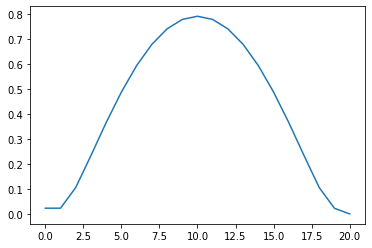

In [688]:
plt.plot(q1)

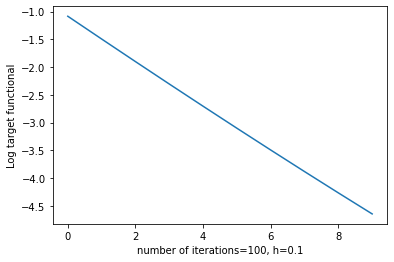

Time elapsed:  15.095792  seconds
0.025 0.00015625000000000003


In [689]:
dx = dx / 2
dt = dx ** 2 / 4
def func(x):
        return (np.sin(np.pi * x)) ** 2

x = np.arange(0, 1, dx)
t = np.arange(0, T, dt)
n = len(t)
m = len(x)
U = np.zeros((n+1,m+1))
e = 0
P = np.zeros((n+1,m+1))
h = 0.1#set yourself
q = np.zeros(m+1)
n_iter = 10 #set yourself
f = np.zeros(m+1)
q_ex = np.zeros(m+1)
for i in range(m+1):
    q_ex[i] = func(dx*i)
  
U = solve_pde_m(q_ex, dx, dt, T, e)
f = U[n,:]

r = np.zeros(n_iter)
grad = np.zeros(m) 
x = np.zeros(n_iter)

for j in range(n_iter):
    time_before = perf_counter_ns()
    P = np.zeros((n+1,m+1))
    U = solve_pde(q, dx, dt, T) #calculating U(t,x|q)
    P = solve_cpde(f, U, dt, dx, T)
    grad =  - P[n, :]  #current grad
    for k in range(m):
        q[k] = q[k] - h * grad[k]
    r[j] = np.log(error(f, U, dx))
    x[j] = j
time_taken = (perf_counter_ns() - time_before) * 1e-6

q2 = np.zeros(m+1)
q2 = q
fig, ax = plt.subplots()
ax.plot(x, r)
ax.set_xlabel('number of iterations=100, h=0.1')
ax.set_ylabel('Log target functional')
plt.show()
print('Time elapsed: ', time_taken, ' seconds')

print(dx, dt)

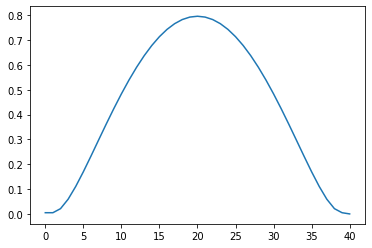

In [690]:
plt.plot(q2)

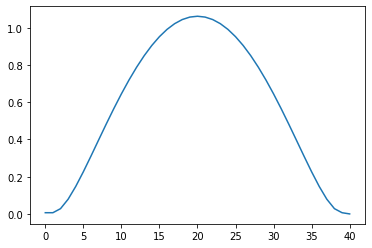

In [691]:
#Richardson's extrapolation for q

from math import floor

q11 = np.zeros(m+1)
for i in range(m+1):
    q11 = q1[floor(i / 2)]

q_star = (4 * q2 - q11) / 3

plt.plot(q_star)

C = np.zeros(m+1)

C = (q11 - q_star) / (dx ** 2)


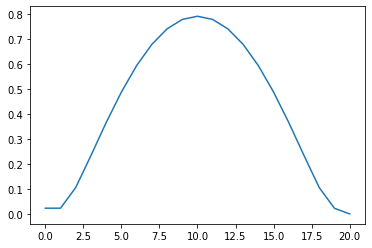

In [692]:
plt.plot(q1)

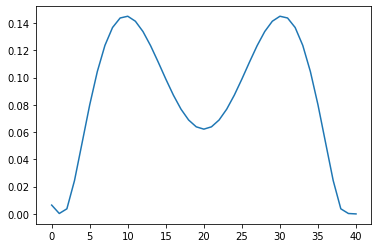

In [693]:
plt.plot(q_star-q_ex)

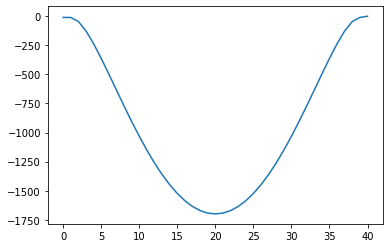

In [694]:
plt.plot(C)